![Brats official annotations](https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg)

# Setup env

In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-l_y3bes1
  Running command git clone -q https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-l_y3bes1
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.0-py3-none-any.whl size=6272 sha256=3105baad2efd7628dc9f94fb5d7e1ede5b3ca053121dc4f5fdb483bf41143c7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-wxrtvag1/wheels/4a/8c/d1/b228c3b67231f7459e8f70d73f4dadaf65cd90692d41f43e88
Successfully built gif-your-nifti
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

# Image data descriptions

All BraTS multimodal scans are available as  NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.



Text(0.5, 1.0, 'Mask')

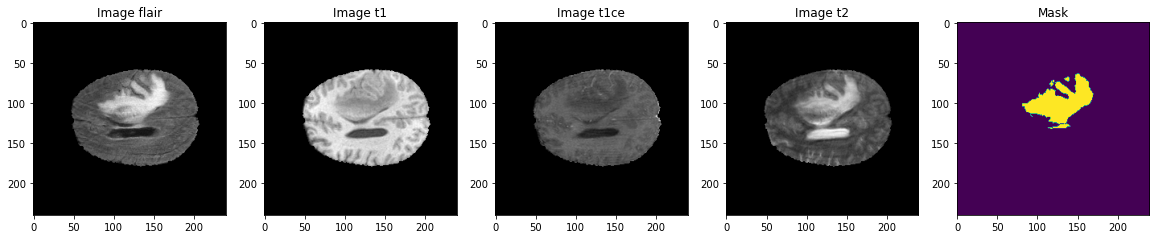

In [4]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


In [ ]:
###____
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()


In [ ]:
###____
he=128
wd=128
test_image_flair = cv2.resize(test_image_flair, (he,wd))
test_image_t1 = cv2.resize(test_image_t1, (he,wd))
test_image_t1ce = cv2.resize(test_image_t1ce, (he,wd))
test_image_t2 = cv2.resize(test_image_t2, (he,wd))

img = [test_image_flair, test_image_t1, test_image_t1ce, test_image_t2]

In [ ]:
###____
img_ = np.array([img[m] for m in range(4)])

In [ ]:
###____
img_x = np.asarray(img_)
img_.shape

In [ ]:
###____


#blob = preprocess(img)
blob = preprocess(imgx)

#in preprocess func
#pred = model.predict(img[None, ...]).squeeze() >= 0.5
pred = model.predict(img)

#changed below
###img = np.load(f'{app.config["UPLOAD_FOLDER"]}/{file}')

import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load and preprocess the data
def load_my_data(file, IMG_SIZE=128, VOLUME_SLICES=100, VOLUME_START_AT=22, n_channels=2):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, n_channels))
    y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, n_channels))

    flair = img = np.load(f'{app.config["UPLOAD_FOLDER"]}/{file[3]}')
    ce = img = np.load(f'{app.config["UPLOAD_FOLDER"]}/{file[2]}')
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return X / np.max(X)

imgx= load_my_data(img)

In [ ]:
###____

niimg = np.load(f'{app.config["UPLOAD_FOLDER"]}/{file[3]}')
#niimg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')


fig, axes = plt.subplots(nrows=3, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

#plt.show()
fig.savefig(f'{path}/gifs/flair.gif')


In [ ]:
###____
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

**Show whole nifti data -> print each slice from 3d data**

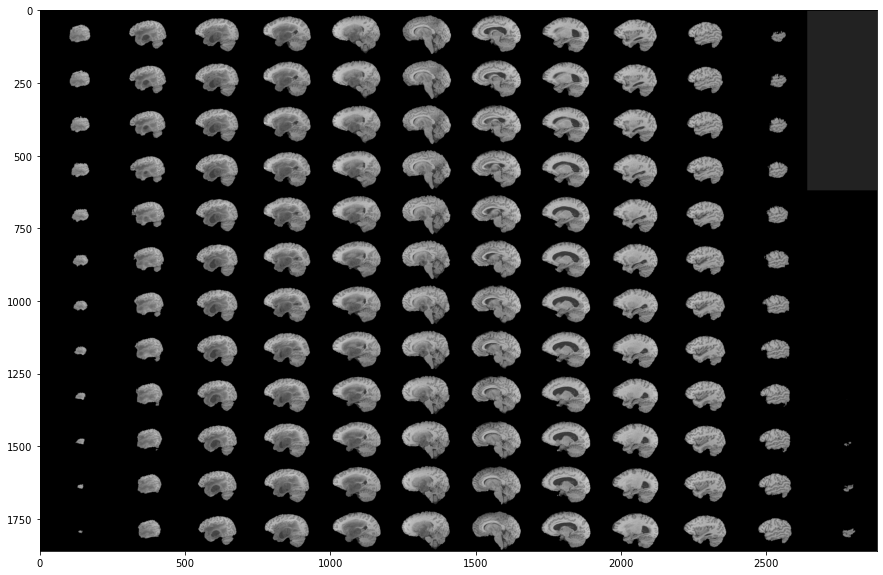

In [8]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

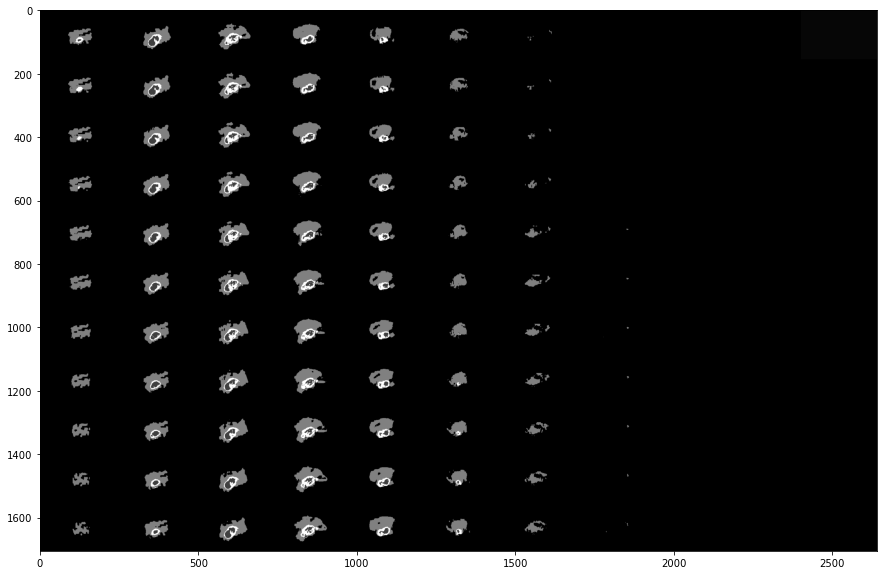

In [9]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [ ]:
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

**Gif representation of slices in 3D volume**
<img src="https://media1.tenor.com/images/15427ffc1399afc3334f12fd27549a95/tenor.gif?itemid=20554734">

**Show segments of tumor using different effects**

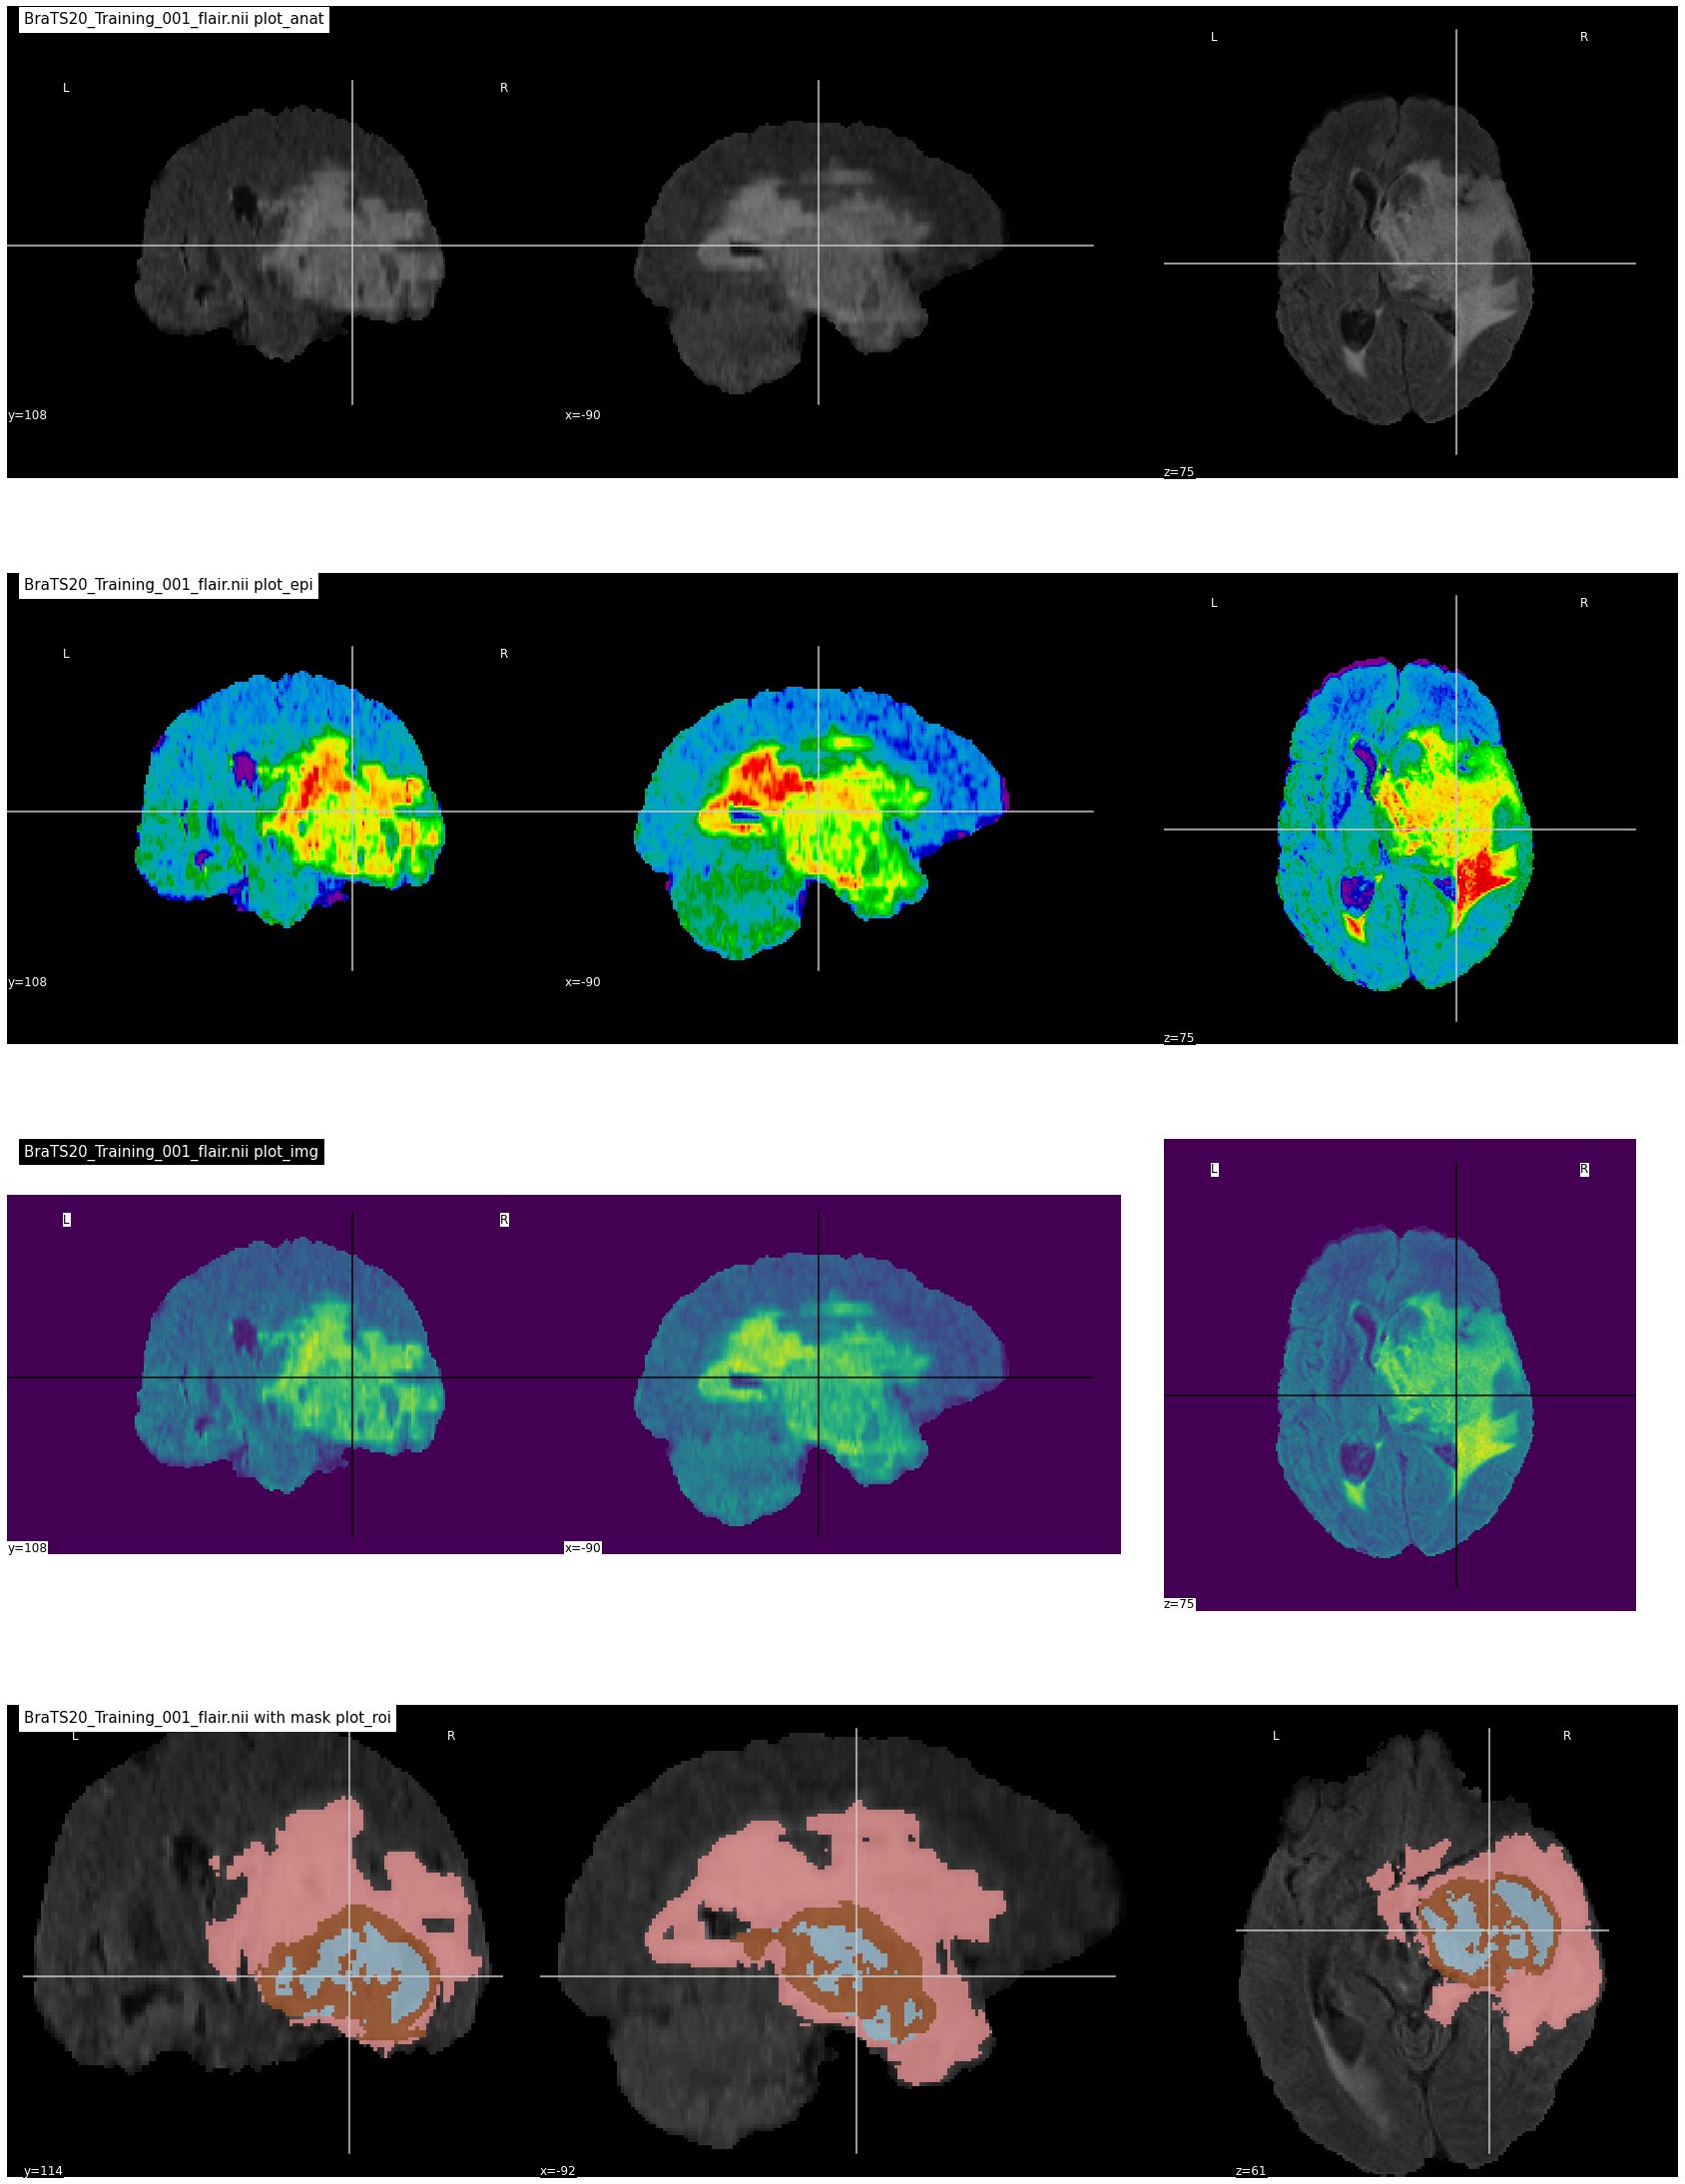

In [5]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [6]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [7]:
IMG_SIZE=128

In [7]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_RCNN(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_RCNN(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

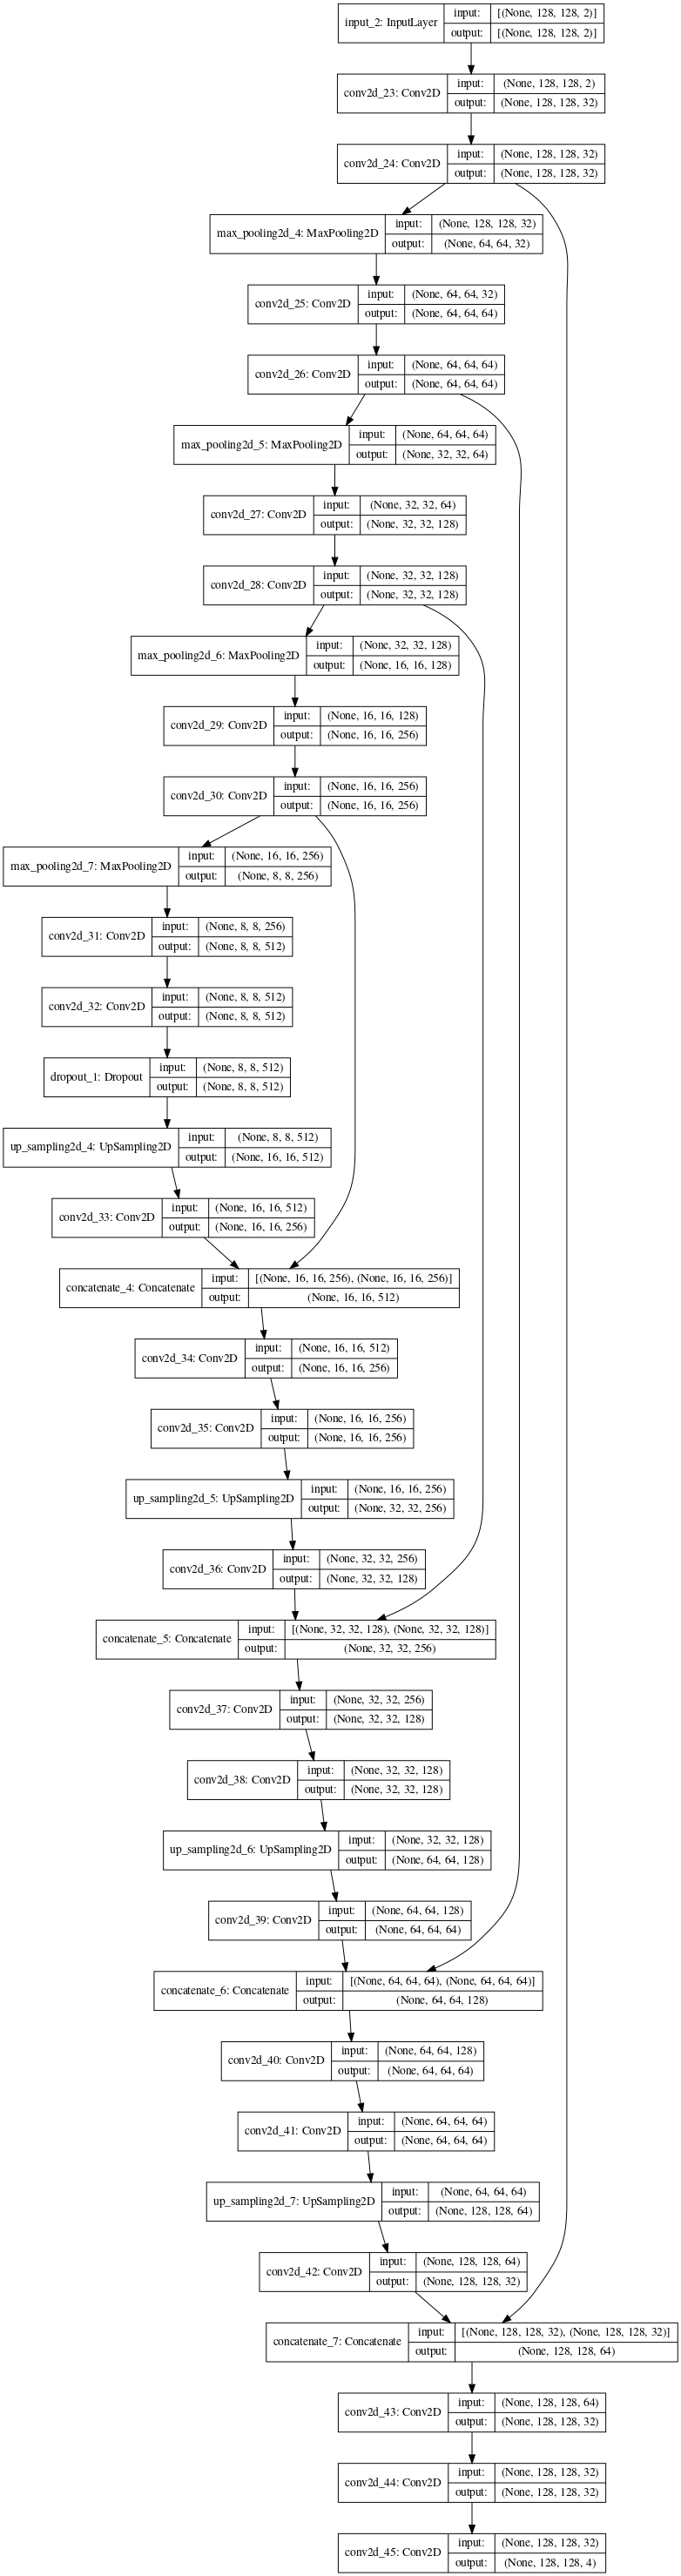

In [15]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [18]:
pip install visualkeras

     |████████████████████████████████| 989 kB 3.9 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import visualkeras

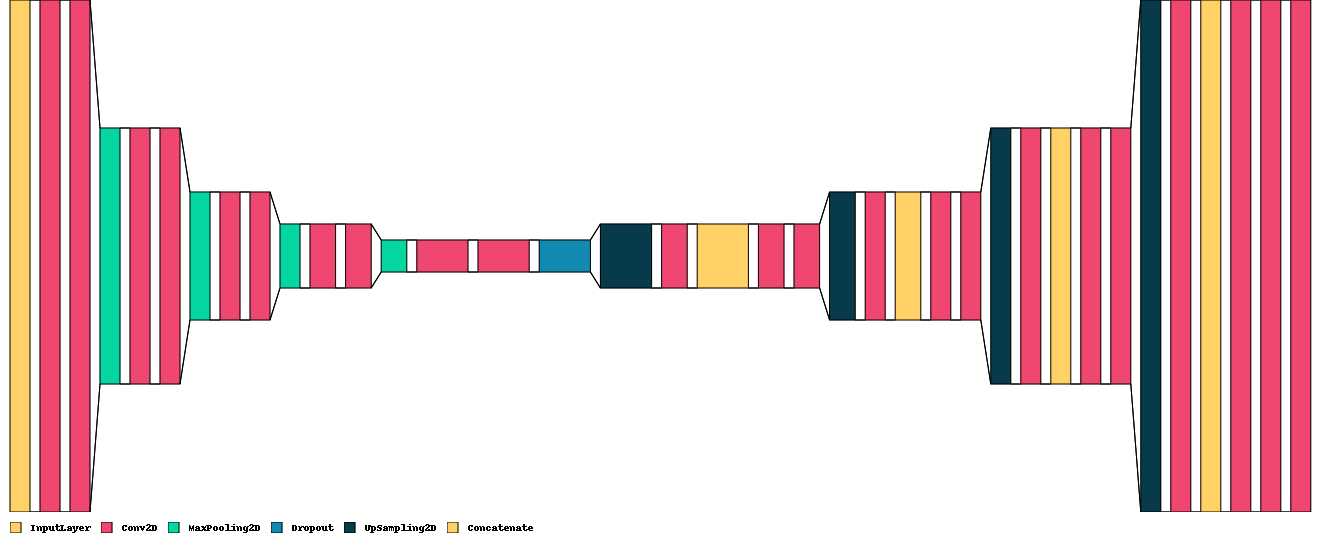

In [29]:
visualkeras.layered_view(model, legend=True, draw_volume=False, to_file='rcnn_visual.png')

In [28]:
plt.savefig('model_visualization.png') # save the image


<Figure size 432x288 with 0 Axes>

**Load Data**

In [12]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

**Override Keras sequence DataGenerator class**

In [10]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used**
for training / testing / validation

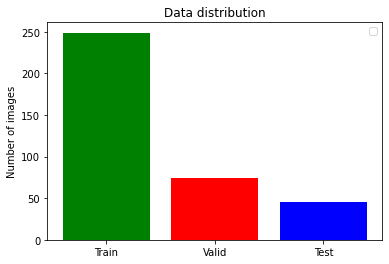

In [21]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig("Dataalayout")
    plt.show()
    
showDataLayout()

**Add callback for training process**

In [10]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

# Train model


In [22]:
K.clear_session()

# history =  model.fit(training_generator,
#                     epochs=35,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )  
# model.save("model_x1_1.h5")

**Visualize the training process**

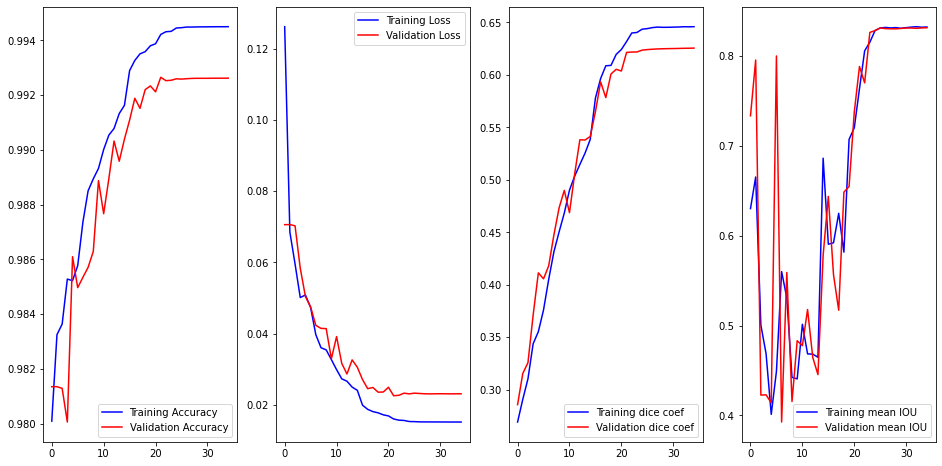

In [24]:
############ load trained model ################
model = keras.models.load_model('../input/modelperclasseval/model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('../input/modelperclasseval/training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [32]:
hist.tail()

,epoch,accuracy,dice_coef,dice_coef_edema,dice_coef_enhancing,dice_coef_necrotic,loss,lr,mean_io_u,precision,...,val_accuracy,val_dice_coef,val_dice_coef_edema,val_dice_coef_enhancing,val_dice_coef_necrotic,val_loss,val_mean_io_u,val_precision,val_sensitivity,val_specificity
30,30,0.994497,0.645542,0.781542,0.717671,0.623957,0.015276,0.000001,0.831832,0.994763,...,0.992616,0.625136,0.744872,0.642582,0.594498,0.023195,0.831392,0.993073,0.991160,0.997664
31,31,0.994498,0.645678,0.781553,0.717516,0.624419,0.015270,0.000001,0.832422,0.994763,...,0.992619,0.625254,0.744977,0.642782,0.594750,0.023181,0.831393,0.993076,0.991162,0.997665
32,32,0.994500,0.645938,0.781399,0.717738,0.624470,0.015264,0.000001,0.832880,0.994761,...,0.992620,0.625369,0.745235,0.642951,0.594993,0.023157,0.831057,0.993078,0.991164,0.997666
33,33,0.994499,0.645868,0.781804,0.717893,0.624320,0.015261,0.000001,0.832259,0.994762,...,0.992619,0.625438,0.745230,0.642755,0.594772,0.023180,0.831523,0.993073,0.991166,0.997664
34,34,0.994501,0.645983,0.781928,0.717942,0.624481,0.015258,0.000001,0.832553,0.994762,...,0.992621,0.625572,0.745259,0.642860,0.595030,0.023177,0.831702,0.993075,0.991169,0.997664


In [1]:
###____
mist = model.predict(data)

NameError: name 'model' is not defined

# Prediction examples 

In [33]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


4/4 [==============================] - 0s 37ms/step


<Figure size 1296x3600 with 0 Axes>

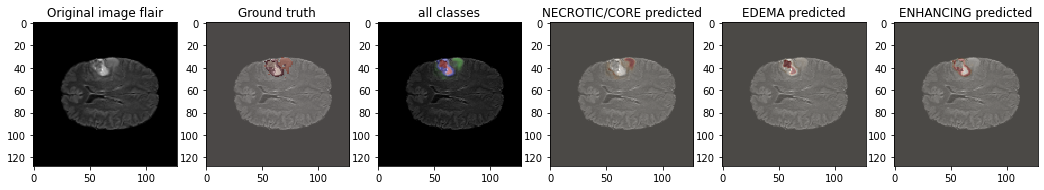

4/4 [==============================] - 0s 36ms/step


<Figure size 432x288 with 0 Axes>

<Figure size 1296x3600 with 0 Axes>

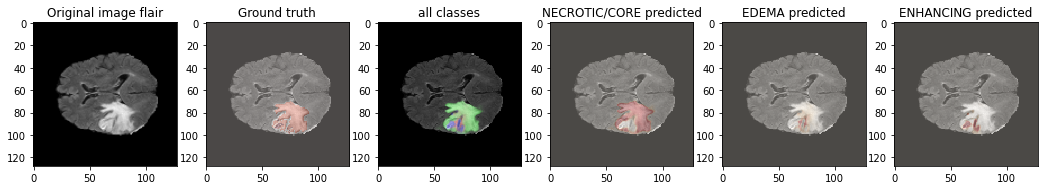

4/4 [==============================] - 0s 36ms/step


<Figure size 432x288 with 0 Axes>

<Figure size 1296x3600 with 0 Axes>

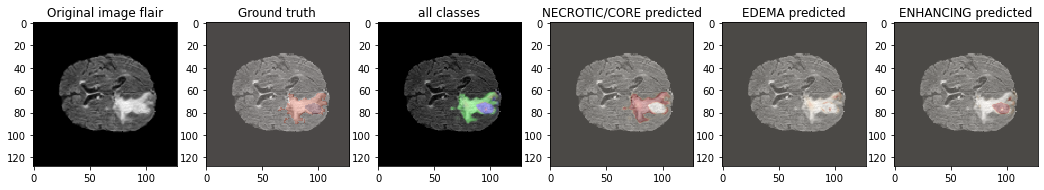

4/4 [==============================] - 0s 34ms/step


<Figure size 432x288 with 0 Axes>

<Figure size 1296x3600 with 0 Axes>

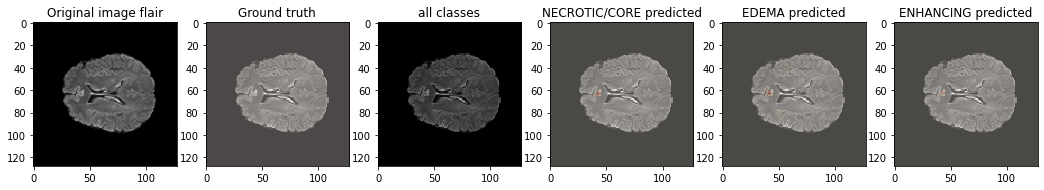

4/4 [==============================] - 0s 34ms/step


<Figure size 432x288 with 0 Axes>

<Figure size 1296x3600 with 0 Axes>

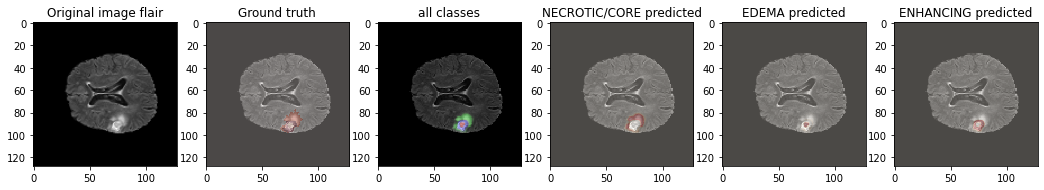

<Figure size 432x288 with 0 Axes>

In [36]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    plt.savefig("data.jpg")
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

###__
converting output to gifs

In [ ]:
import imageio
import cv2

In [ ]:
def showPredictsById_(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]
    
    '''

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')    
    
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)    
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'   
    axarr[1].title.set_text('Ground truth')
    
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    '''
    return core, edema, enhancing, origImage, p
    
    
core, edema, enhancing, origImage, p = showPredictsById_(case=test_ids[0][-3:])


In [ ]:
start_slice = 60
IMG_SIZE = 128

In [ ]:
print(origImage.shape)
print(core.shape)
print(edema.shape)

In [ ]:
img1_ = cv2.resize(origImage[:,:,82], (128, 128))

In [ ]:
img1_ = img1[82,:,]

In [ ]:
img1_.shape

In [ ]:
edema.dtype
img1 = cv2.resize(origImage[:,:,82], (128, 128))
img1 = img1.astype('float32')

In [ ]:
img2 = core[60,:,]

In [ ]:
#imgAllclasses = cv2.resize(gt[:,:,start_slice+22], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)    
imgCore = core[start_slice,:,]
imgEdema = edema[start_slice,:,:]
imgEnhancing = enhancing[start_slice,:,]

imgAll = p[start_slice,:,:,1:4]

In [ ]:
plt.figure(figsize=(128,128))
plt.imshow(img1_, cmap="gray", interpolation='none')
plt.imshow(imgAll, cmap="Reds", interpolation='none', alpha=0.3)
plt.savefig("AllClasses.jpg")


In [ ]:

plt.figure(figsize=(18,50), dpi=300)
plt.imshow(img1_, cmap="gray", interpolation='none')
plt.imshow(imgEdema, cmap="Greens", interpolation='none', alpha=0.3)
plt.savefig("Edema.jpg")


In [ ]:
plt.figure(figsize=(18,50))
plt.imshow(img1_, cmap="gray", interpolation='none')
plt.imshow(imgCore, cmap="OrRd", interpolation='none', alpha=0.3)
plt.savefig("Core.jpg")


In [ ]:
plt.figure(figsize=(18,50))
plt.imshow(img1_, cmap="gray", interpolation='none')
plt.imshow(imgEnhancing, cmap="Purples", interpolation='none', alpha=0.3)
plt.savefig("enhancing.jpg")


In [ ]:
img3 = cv2.addWeighted(img1_, 0.5, img2, 0.5, 0)

In [ ]:
plt.imshow(img2)

In [ ]:
imageio.mimsave("core.gif", [get(i, core) for i in range(core.shape[0])])

In [ ]:
core_ = np.array(core)

In [ ]:
alpha = 0.4
#my_img = cv2.resize(origImage[:,:,82], (128, 128))
cv2.addWeighted(core[60,:,], alpha, my_img, 1-alpha, 0, core_)

In [ ]:
plt.imshow(core_[60,:,])

In [ ]:
imageio.mimsave("core_ba.gif", [core_[i,:,] for i in range(core_.shape[0])])

In [ ]:
cv2.imwrite("img3.jpg", img3)

# Evaluation

4/4 [==============================] - 0s 36ms/step


<Figure size 432x288 with 0 Axes>

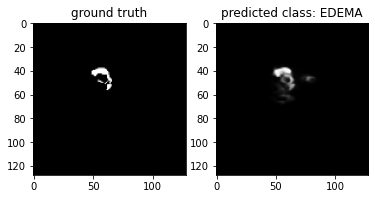

In [44]:
case = case=test_ids[3][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [51]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate RCNN on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate RCNN on test data
45/45 [==============================] - 14s 282ms/step - loss: 0.0226 - accuracy: 0.9919 - mean_io_u_8: 0.8284 - dice_coef: 0.6369 - precision: 0.9925 - sensitivity: 0.9903 - specificity: 0.9975 - dice_coef_necrotic: 0.5976 - dice_coef_edema: 0.7991 - dice_coef_enhancing: 0.6839
test loss, test acc: [0.019863532856106758, 0.9931951761245728, 0.8293207883834839, 0.6376627087593079, 0.993656575679779, 0.9917352199554443, 0.9978668093681335, 0.6259851455688477, 0.7825247049331665, 0.6790826916694641]


# Loading data for testing other models

In [ ]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load and preprocess the data
def load_data(list_IDs, IMG_SIZE, VOLUME_SLICES, VOLUME_START_AT, TRAIN_DATASET_PATH):
    X = np.zeros((len(list_IDs) * VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    y = np.zeros((len(list_IDs) * VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4))

    for c, i in enumerate(list_IDs):
        case_path = os.path.join(TRAIN_DATASET_PATH, i)

        data_path = os.path.join(case_path, f'{i}_flair.nii')
        flair = nib.load(data_path).get_fdata()

        data_path = os.path.join(case_path, f'{i}_t1ce.nii')
        ce = nib.load(data_path).get_fdata()

        data_path = os.path.join(case_path, f'{i}_seg.nii')
        seg = nib.load(data_path).get_fdata()

        for j in range(VOLUME_SLICES):
            X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
            X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

            curr_seg = seg[:, :, j + VOLUME_START_AT]
            curr_seg[curr_seg == 4] = 3
            mask = tf.one_hot(curr_seg, 4)
            y[j + VOLUME_SLICES * c] = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE)).numpy()

    return X / np.max(X), y

# Split data into train, validation, and test sets
all_ids = train_and_test_ids[:15]  # Load or define your list of all IDs here
train_ids, test_ids = train_test_split(all_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Load train, validation, and test data
X_train, y_train = load_data(train_ids, IMG_SIZE, VOLUME_SLICES, VOLUME_START_AT, TRAIN_DATASET_PATH)
X_val, y_val = load_data(val_ids, IMG_SIZE, VOLUME_SLICES, VOLUME_START_AT, TRAIN_DATASET_PATH)
X_test, y_test = load_data(test_ids, IMG_SIZE, VOLUME_SLICES, VOLUME_START_AT, TRAIN_DATASET_PATH)


In [ ]:
##__For making observations

#train_ids
#test_ids
#len(y_test)
#fcn2_input_shape = X_train[0].shape
X = np.zeros((len(all_ids) * VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
print(X_train.shape)
print(X_train[0].shape)
#len(train_ids)
#X_val.shape
print(X.shape)
print(len(X))

## **FCN NeTwork**

In [47]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose, concatenate
from keras.models import Model
import keras
import tensorflow as tf

def build_fcn(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)

    up5 = Conv2DTranspose(128, 2, strides=2, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)

    up6 = Conv2DTranspose(64, 2, strides=2, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up7 = Conv2DTranspose(32, 2, strides=2, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
    
    conv8 = Conv2D(4, 1, activation='softmax')(conv7)
    
    return Model(inputs=inputs, outputs=conv8)
    
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
    
fcn_model = build_fcn(input_layer, 'he_normal', 0.2)
fcn_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])
fcn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

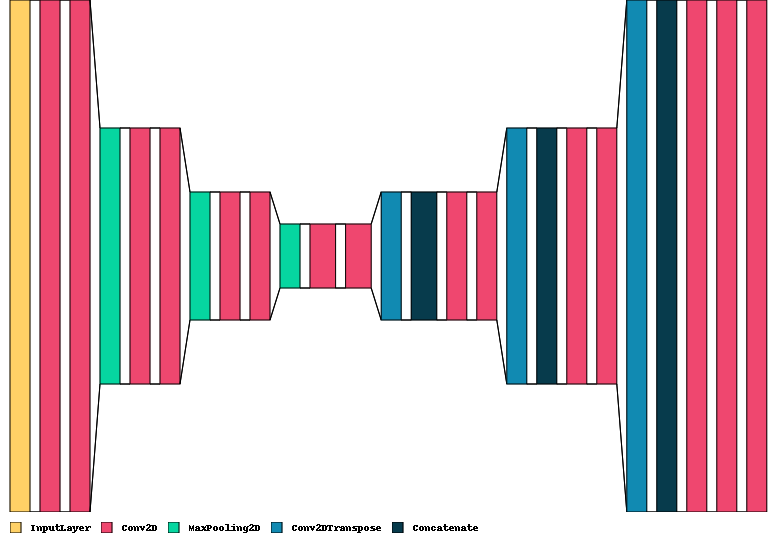

In [31]:
visualkeras.layered_view(fcn_model, legend=True, draw_volume=False, to_file='fnn_visual.png')

In [48]:
history =  fcn_model.fit(X_train, y_train,
                     epochs=10,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = (X_val, y_val)
                     )  
fcn_model.save("fcn_model_x1_1.h5")

Epoch 1/10
6/6 [==============================] - 7s 497ms/step - loss: 1.1639 - accuracy: 0.8818 - mean_io_u_5: 0.4197 - dice_coef: 0.1550 - precision: 0.6057 - sensitivity: 0.3150 - specificity: 0.9976 - dice_coef_necrotic: 0.0099 - dice_coef_edema: 0.0475 - dice_coef_enhancing: 0.0162 - val_loss: 0.6695 - val_accuracy: 0.9769 - val_mean_io_u_5: 0.3756 - val_dice_coef: 0.2115 - val_precision: 0.9717 - val_sensitivity: 0.7404 - val_specificity: 0.9922 - val_dice_coef_necrotic: 7.0638e-06 - val_dice_coef_edema: 0.0012 - val_dice_coef_enhancing: 2.4840e-05
Epoch 2/10
6/6 [==============================] - 2s 287ms/step - loss: 0.4899 - accuracy: 0.9846 - mean_io_u_5: 0.3938 - dice_coef: 0.2071 - precision: 0.9769 - sensitivity: 0.7359 - specificity: 0.9948 - dice_coef_necrotic: 0.0109 - dice_coef_edema: 0.0413 - dice_coef_enhancing: 0.0129 - val_loss: 0.8802 - val_accuracy: 0.9769 - val_mean_io_u_5: 0.5609 - val_dice_coef: 0.2477 - val_precision: 0.9767 - val_sensitivity: 0.9766 - val_s

 Evaluating FCN model

In [50]:
fcn_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate fcn on test data")
results = fcn_model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate fcn on test data
45/45 [==============================] - 14s 278ms/step - loss: 0.0859 - accuracy: 0.9841 - mean_io_u_7: 0.3756 - dice_coef: 0.2579 - precision: 0.9840 - sensitivity: 0.9840 - specificity: 0.9947 - dice_coef_necrotic: 0.0109 - dice_coef_edema: 0.0551 - dice_coef_enhancing: 0.0218
test loss, test acc: [0.09439094364643097, 0.9821909666061401, 0.37561729550361633, 0.25871169567108154, 0.9821264743804932, 0.9821552634239197, 0.9940568804740906, 0.013678145594894886, 0.05446820333600044, 0.026105472818017006]


## **YOLO NETWORK 1**

In [52]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=not use_bn, kernel_initializer='he_normal')(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

def darknet53(inputs):
    x = conv_block(inputs, 32, 3, strides=1)
    x = conv_block(x, 64, 3, strides=2)
    for _ in range(1):
        x = conv_block(x, 32, 1, strides=1)
        x = conv_block(x, 64, 3, strides=1)
    x = conv_block(x, 128, 3, strides=2)
    for _ in range(2):
        x = conv_block(x, 64, 1, strides=1)
        x = conv_block(x, 128, 3, strides=1)
    x = conv_block(x, 256, 3, strides=2)
    for _ in range(8):
        x = conv_block(x, 128, 1, strides=1)
        x = conv_block(x, 256, 3, strides=1)
    route_1 = x
    x = conv_block(x, 512, 3, strides=2)
    for _ in range(8):
        x = conv_block(x, 256, 1, strides=1)
        x = conv_block(x, 512, 3, strides=1)
    route_2 = x
    x = conv_block(x, 1024, 3, strides=2)
    for _ in range(4):
        x = conv_block(x, 512, 1, strides=1)
        x = conv_block(x, 1024, 3, strides=1)
    return route_1, route_2, x

def yolo_segmentation_model(input_shape=(128, 128, 2), num_classes=4):
    inputs = layers.Input(input_shape)
    route_1, route_2, x = darknet53(inputs)
    
    x = layers.Conv2D(512, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.concatenate([x, route_2])
    
    x = layers.Conv2D(256, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.concatenate([x, route_1])
    
    x = layers.Conv2D(128, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    
    # Add additional upsampling layer
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    
    x = layers.Conv2D(num_classes, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.Activation('softmax')(x)

    model = Model(inputs, x)
    return model

yolo_model = yolo_segmentation_model()
yolo_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
yolo_model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 32) 576         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_15[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

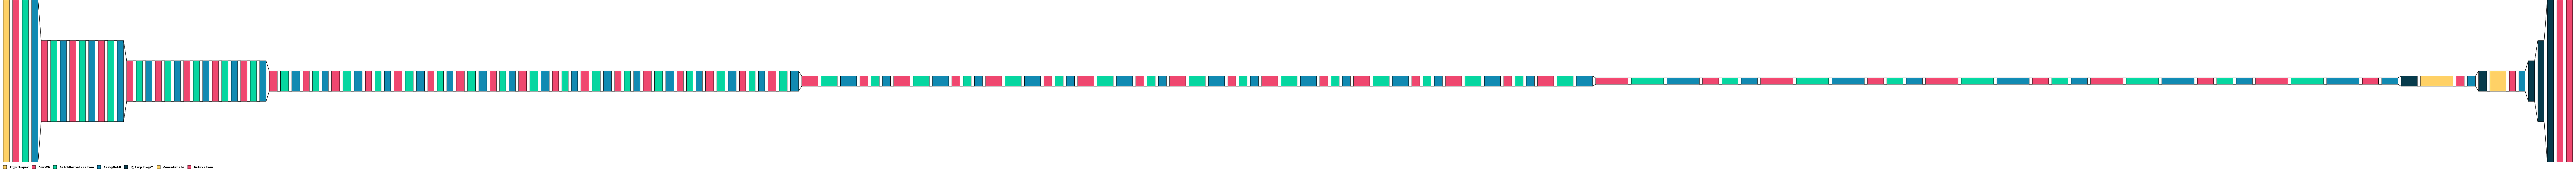

In [33]:
visualkeras.layered_view(yolo_model, legend=True, draw_volume=False, to_file='yolo_visual.png')

In [55]:
history =  yolo_model.fit(X_train, y_train,
                     epochs=10,
                     steps_per_epoch=len(train_ids),
                     #callbacks= callbacks,
                     validation_data = (X_val, y_val)
                     )  
yolo_model.save("yolo_model_x1_1.h5")

Epoch 1/10
6/6 [==============================] - 2s 358ms/step - loss: 0.0628 - accuracy: 0.9849 - val_loss: 278013.9375 - val_accuracy: 0.9769
Epoch 2/10
6/6 [==============================] - 2s 331ms/step - loss: 0.0554 - accuracy: 0.9851 - val_loss: 117276.0469 - val_accuracy: 0.9769
Epoch 3/10
6/6 [==============================] - 2s 331ms/step - loss: 0.0472 - accuracy: 0.9851 - val_loss: 47947.9258 - val_accuracy: 0.9769
Epoch 4/10
6/6 [==============================] - 2s 332ms/step - loss: 0.0456 - accuracy: 0.9856 - val_loss: 12654.3242 - val_accuracy: 0.9769
Epoch 5/10
6/6 [==============================] - 2s 332ms/step - loss: 0.0396 - accuracy: 0.9861 - val_loss: 2996.8694 - val_accuracy: 0.9769
Epoch 6/10
6/6 [==============================] - 2s 332ms/step - loss: 0.0351 - accuracy: 0.9875 - val_loss: 657.6761 - val_accuracy: 0.9766
Epoch 7/10
6/6 [==============================] - 2s 342ms/step - loss: 0.0312 - accuracy: 0.9881 - val_loss: 139.8838 - val_accuracy: 0.

In [57]:
yolo_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate yolo on test data")
results = yolo_model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate yolo on test data
45/45 [==============================] - 15s 270ms/step - loss: 0.1356 - accuracy: 0.9782 - mean_io_u_10: 0.6107 - dice_coef: 0.2592 - precision: 0.9785 - sensitivity: 0.9780 - specificity: 0.9928 - dice_coef_necrotic: 0.0095 - dice_coef_edema: 0.0562 - dice_coef_enhancing: 0.0148
test loss, test acc: [0.10905472934246063, 0.9819803833961487, 0.6122997403144836, 0.2596810758113861, 0.9825243353843689, 0.9816757440567017, 0.9941697716712952, 0.009745248593389988, 0.060246456414461136, 0.019366173073649406]


In [ ]:
image = X_train[1][:,:,:]
#plt.imshow(image)
image.shape

**RCN**

In [ ]:
import numpy as np
import os
import skimage.io
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from keras.optimizers import Adam

# Define the Mask R-CNN model
def create_mask_rcnn_model(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoding path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # Output layer
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    
    return model

# Training
def train_mask_rcnn_model():
    # Set up the model
    input_shape = (256, 256, 4)  # Adjust input shape according to your dataset
    num_classes = 2  # Background and tumor
    model = create_mask_rcnn_model(input_shape, num_classes)
    
    # Compile the model
    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Load the dataset (BRATs 2018)
    # Adjust the path according to your dataset location
    train_images_path = 'path_to_train_images'
    train_masks_path = 'path_to_train_masks'
    train_images = []
    train_masks = []
    
    for filename in os.listdir(train_images_path):
        if filename.endswith(".nii.gz"):
            image_path = os.path.join(train_images_path, filename)
            mask_path = os.path.join(train_masks_path, filename)
            image = skimage.io.imread(image_path)
            mask = skimage.io.imread(mask_path)
            train_images.append(image)
            train_masks.append(mask)
    
    train_images = np.array(train_images)
    train_masks = np.array(train_masks)
    
    # Normalize and preprocess the images and masks
    
    # Split the dataset into training and validation sets
    
    # Train the model
    
    # Save the trained model
    
    # Evaluate the model on the test set
    
    # Return the trained model



In [ ]:
# Run the training
train_mask_rcnn_model()

## **Evaluation**

4/4 [==============================] - 1s 93ms/step


<Figure size 1296x3600 with 0 Axes>

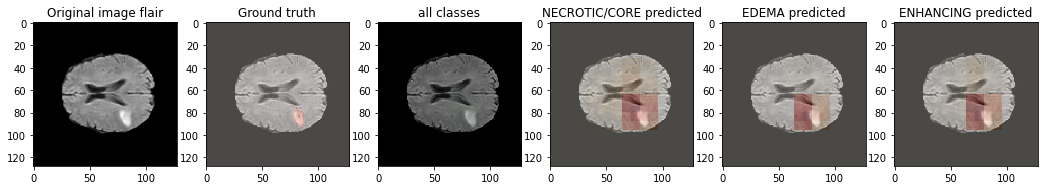

4/4 [==============================] - 0s 40ms/step


<Figure size 1296x3600 with 0 Axes>

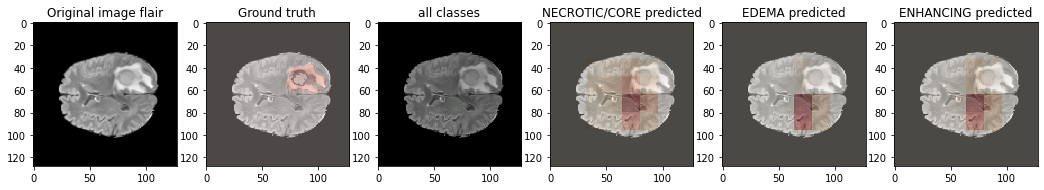

IndexError: list index out of range

In [58]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return yolo_model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()